___
# <font color= #d4b1e6> **Proyecto 3: Sentiment Analysis RELOADED** </font>
- <Strong> Nombre de los integrantes: </Strong>  <font color="blue">`Sarah Lucía Beltrán, Priscila Cervantes Ramírez & Mónica Ibarra Herrera` </font>
- <Strong> Materia: </Strong>  <font color="blue">`Minería de Textos` </font>
___

### <font color= #d4b1e6> **Introducción** </font>

En este proyecto se utilizó un conjunto de datos llamado “Social Media Engagement”, que contiene información sobre publicaciones en distintas redes sociales, como la plataforma, hashtags, cantidad de comentarios y más.
El objetivo fue analizar el sentimiento de las publicaciones y comentarios sobre Nike y Adidas, dos marcas que compiten directamente en el mercado deportivo.

Para lograrlo, aplicamos distintas técnicas de procesamiento de lenguaje natural (NLP), combinando métodos clásicos y modernos. Entre ellos usamos TF-IDF, regresión logística, BERT, además de herramientas como POS y NER, que ayudaron a mejorar la precisión y el entendimiento del texto.
Con esto, buscamos no solo clasificar los sentimientos, sino también entender mejor cómo las personas perciben a cada marca en redes sociales.

### <font color= #d4b1e6> **Librerías** </font>

In [ ]:
import random, re, numpy as np, torch
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import evaluate
import torch
from datasets import Dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader


RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


impirtación de librerías:

- random, numpy, torch --> control de aleatroriedad y manejo de tensores
- pandas --> manejo de dataframes   
- sklearn --> vectorización, modelos lineales y métricas.
- scipy.sparse --> manejo de matrices dispersas
- matplotlib, seaborn --> visualización de datos
- transformers --> carga del modelo BERT y tokenizador
- spacy --> procesamiento de lenguaje natural
- eval --> evaluación de modelos


In [ ]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


Se fija una semilla inicial aleatoria para que los resultados puedan ser reproducibles. Se detecta si hay GPU disponible y sino CPU.

### <font color= #d4b1e6> **Cargar datos** </font>

In [38]:
data=pd.read_csv('Social Media Engagement Dataset.csv')
data.head()

,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,kcqbs6hxybia,2024-12-09 11:26:15,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,#Food,NaN,...,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1
1,vkmervg4ioos,2024-07-28 19:59:26,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,"#MustHave, #Food","@CustomerService, @BrandCEO",...,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6
2,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,...,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
3,bhyo6piijqt9,2024-09-16 04:35:25,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,"#Reviews, #Sustainable","@StyleGuide, @BrandSupport",...,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5
4,c9dkiomowakt,2024-09-05 21:03:01,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,"#Health, #Travel","@BrandSupport, @InfluencerName",...,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8


Carga y visualización del dataset

### <font color= #d4b1e6> **Información de dataset** </font>

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   post_id                  12000 non-null  object 
 1   timestamp                12000 non-null  object 
 2   day_of_week              12000 non-null  object 
 3   platform                 12000 non-null  object 
 4   user_id                  12000 non-null  object 
 5   location                 12000 non-null  object 
 6   language                 12000 non-null  object 
 7   text_content             12000 non-null  object 
 8   hashtags                 12000 non-null  object 
 9   mentions                 8059 non-null   object 
 10  keywords                 12000 non-null  object 
 11  topic_category           12000 non-null  object 
 12  sentiment_score          12000 non-null  float64
 13  sentiment_label          12000 non-null  object 
 14  emotion_type          

Podemos observar que de 12,000 entradas, únciamente en la columna de `mentions` contiene valores nulos.

Contamos con 28 columnas, 18 son object, 6 flotantes y 4 enteros.

### <font color= #d4b1e6> **Valores de la columna de marcas** </font>

In [40]:
data['brand_name'].value_counts()

,count
brand_name,
Microsoft,1239
Adidas,1229
Nike,1219
Google,1216
Samsung,1216
Pepsi,1199
Apple,1192
Toyota,1174
Coca-Cola,1173


Se puede visualizar los valores de la columna `brand_name`, entre ellos Nike y Adidas.

### <font color= #d4b1e6> **Filtrar datos Adidas vs Nike** </font>

In [41]:
filtered_data = data[data['brand_name'].isin(['Adidas', 'Nike'])].copy()
filtered_data = filtered_data.reset_index(drop=True)
filtered_data

,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,...,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,"#Promo, #Food, #Trending",NaN,...,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
1,e8rzr949rzkr,2024-07-28 03:21:09,Sunday,Reddit,user_jzvf44eq,"Seoul, South Korea",pt,Nike PowerRelease is subpar! Can't wait to see...,#Discount,NaN,...,441,7734,0.64908,Nike,React,CyberMonday,Pre-Launch,0.9095,-0.4563,16.0
2,s3jm9lrx9f12,2024-10-23 05:30:02,Wednesday,Twitter,user_2623g2ql,"Beijing, China",ar,Attended the Adidas FallCollection event yeste...,"#Food, #TrendAlert",NaN,...,952,55896,0.07148,Adidas,Predator,SustainableFuture,Launch,0.2809,0.4181,-3.2
3,9fi7edo1vekz,2025-01-25 23:02:17,Saturday,YouTube,user_z9zzi99c,"New York, USA",hi,Just unboxed my new Dri-FIT from Nike. Wouldn'...,"#SpecialOffer, #Sale",@ReviewSite,...,243,49506,0.08796,Nike,Dri-FIT,HolidaySpecial,Post-Launch,-0.4698,0.3882,68.6
4,642fmlinklpt,2024-12-02 18:08:08,Monday,YouTube,user_z2r9v1ms,"Los Angeles, USA",es,Just saw an ad for Nike FlyKnit during the Loy...,"#Sale, #Affordable, #TrendAlert",NaN,...,972,29735,0.09450,Nike,FlyKnit,NewYearNewYou,Post-Launch,0.2889,-0.0493,-24.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,0iml18xr1an8,2024-07-13 20:48:40,Saturday,Twitter,user_w0qemyy5,"Cairo, Egypt",ja,Just unboxed my new FlyKnit from Nike. Returni...,#TrendAlert,"@RetailSupport, @BrandSupport",...,344,78777,0.03691,Nike,FlyKnit,InnovationX,Post-Launch,-0.1153,0.1881,78.1
2444,za9potb327tg,2024-05-18 23:29:47,Saturday,Reddit,user_3v2xfjzf,Singapore,ar,Can't contain my excitement with my new React ...,"#SpecialOffer, #Fashion, #BestValue","@IndustryExpert, @TrendSetter",...,734,61807,0.07227,Nike,React,NextGeneration,Pre-Launch,-0.5499,-0.3271,-9.2
2445,re51xr0m9z53,2025-04-05 23:46:20,Saturday,YouTube,user_hm05dgne,"Rome, Italy",ru,Fed up with my new Epic React from Nike! Excee...,"#Quality, #Promo, #Food",@ProductTeam,...,613,69126,0.03607,Nike,Epic React,InnovationX,Post-Launch,0.2219,0.1643,-73.6
2446,e9c83vkjm10x,2024-07-21 11:11:58,Sunday,YouTube,user_ik7il4dp,"Seoul, South Korea",zh,Thrilled with my new Dri-FIT from Nike! Absolu...,#Quality,"@RetailSupport, @StyleGuide",...,497,67468,0.04258,Nike,Dri-FIT,LaunchWave,Launch,-0.7145,-0.2419,49.9


Se realiza un filtro donde solo las publicaciones de las marcas *Adidas* y *Nike* son consideradas para el análisis de sentimiento.

### <font color= #d4b1e6> **Limpieza de datos** </font>

In [ ]:
# Limpieza y preparación de datos
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

filtered_data['clean_text'] = filtered_data['text_content'].apply(clean_text)
filtered_data['label'] = filtered_data['sentiment_label'].map({'Positive':1, 'Negative':0})
filtered_data = filtered_data.dropna(subset=['clean_text','label'])
filtered_data['label'] = filtered_data['label'].astype(int)

train_df, temp_df = train_test_split(filtered_data, test_size=0.3, stratify=filtered_data['label'], random_state=RANDOM_SEED)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=RANDOM_SEED)

y_train = train_df['label'].values
y_val   = val_df['label'].values
y_test  = test_df['label'].values

/tmp/ipython-input-2005537346.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['label'] = filtered_data['label'].astype(int)


Lo que realiza la función es que limpia el texto para eliminar caracteres especiales, URLs, menciones y hashtags, dejando solo el texto relevante para el análisis de sentimiento.

Crea una nueva columna llamada `clean_text`, y pone etiquetas donde 0 es negativo y 1 positivo.

Se hace la división del dataset donde el 70% es para entrenamiento, 15% para validación y 15% para prueba.

### <font color= #d4b1e6> **Baseline** </font>

In [ ]:
# TF-IDF baseline
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_features=25000)
X_train_tfidf = tfidf.fit_transform(train_df['clean_text'])
X_val_tfidf   = tfidf.transform(val_df['clean_text'])
X_test_tfidf  = tfidf.transform(test_df['clean_text'])

clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED)
clf.fit(X_train_tfidf, y_train)


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

`TfidfVectorizer` convierte el texto a vectores y se basa en sus frecuencias de palabras y bigramas.

En logistic regression es modelo base de clasificación binaria.

### <font color= #d4b1e6> **POS y NER** </font>

In [ ]:
# POS y NER counts
nlp = spacy.load("en_core_web_sm")

def pos_ner_counts(text):
    doc = nlp(text)
    return Counter([t.pos_ for t in doc]), Counter([e.label_ for e in doc.ents])

def build_pos_ner_matrices(texts, top_pos=None, top_ner=None):
    pos_list, ner_list, agg_pos, agg_ner = [], [], Counter(), Counter()
    for t in texts:
        p,n = pos_ner_counts(t)
        pos_list.append(p)
        ner_list.append(n)
        agg_pos.update(p)
        agg_ner.update(n)
    if top_pos is None: top_pos = [p for p,_ in agg_pos.most_common(30)]
    if top_ner is None: top_ner = [n for n,_ in agg_ner.most_common(20)]

    Xpos = np.array([[p.get(k,0) for k in top_pos] for p in pos_list], dtype=float)
    Xner = np.array([[n.get(k,0) for k in top_ner] for n in ner_list], dtype=float)
    return Xpos, Xner, top_pos, top_ner

Xpos_train, Xner_train, top_pos_list, top_ner_list = build_pos_ner_matrices(train_df['clean_text'])
Xpos_val, Xner_val, _, _ = build_pos_ner_matrices(val_df['clean_text'], top_pos_list, top_ner_list)
Xpos_test, Xner_test, _, _ = build_pos_ner_matrices(test_df['clean_text'], top_pos_list, top_ner_list)

X_train_full = hstack([X_train_tfidf, csr_matrix(Xpos_train), csr_matrix(Xner_train)])
X_val_full   = hstack([X_val_tfidf, csr_matrix(Xpos_val), csr_matrix(Xner_val)])

clf_posner = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED)
clf_posner.fit(X_train_full, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

Se carga el modelo de Spacy que detecta POS y NER.

En las funciones de pos_ner_counts cuenta los tipos gramaticales y entidades y para el build_pos_ner_matrices construye matrices numéricas con esos conteos.

Por último, combinan las características de cada uno para mejorar el modelo.

### <font color= #d4b1e6> **POS n-grams** </font>

In [ ]:
# POS n-grams
def pos_sequence(text): return " ".join([t.pos_ for t in nlp(text)])
train_pos_seq = train_df['clean_text'].apply(pos_sequence)
val_pos_seq   = val_df['clean_text'].apply(pos_sequence)
pos_ngram_vect = TfidfVectorizer(ngram_range=(2,3), min_df=5)
Xposng_train = pos_ngram_vect.fit_transform(train_pos_seq)
Xposng_val   = pos_ngram_vect.transform(val_pos_seq)
clf_posng = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED)
clf_posng.fit(Xposng_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

Convierte el texto en una secuencia de etiquetas POS y usa TF-IDF para capturar secuencias o patrones sintácticos.

### <font color= #d4b1e6> **NER-enhanced n-grams** </font>

In [ ]:
# NER-enhanced n-grams
def replace_ents(text):
    doc = nlp(text)
    tokens, skip_until = [], -1
    ent_intervals = {(ent.start, ent.end): ent.label_ for ent in doc.ents}
    for i, token in enumerate(doc):
        if i < skip_until: continue
        found=False
        for (s,e), lab in ent_intervals.items():
            if s==i: tokens.append(lab); skip_until=e; found=True; break
        if not found: tokens.append(token.text)
    return " ".join(tokens)

train_ner_rep = train_df['clean_text'].apply(replace_ents)
val_ner_rep   = val_df['clean_text'].apply(replace_ents)
tfidf_ner = TfidfVectorizer(ngram_range=(1,2), min_df=5)
Xnerrep_train = tfidf_ner.fit_transform(train_ner_rep)
Xnerrep_val   = tfidf_ner.transform(val_ner_rep)
clf_nerrep = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED)
clf_nerrep.fit(Xnerrep_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

Se reemplazan las entidades nombradas por el tipo de brand, esto permite que el modelo aprenda patrones más generales sin depender de nombres específicos.

### <font color= #d4b1e6> **Transformer-based model** </font>

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "vinai/bertweet-base"

# Tokenizer y datasets HF
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize(batch):
    return tokenizer(batch['clean_text'], padding="max_length", truncation=True, max_length=128)

hf_train = Dataset.from_pandas(train_df[['clean_text','label']])
hf_val   = Dataset.from_pandas(val_df[['clean_text','label']])
hf_train = hf_train.map(tokenize, batched=True)
hf_val   = hf_val.map(tokenize, batched=True)
hf_train.set_format(type='torch', columns=['input_ids','attention_mask','label'])
hf_val.set_format(type='torch', columns=['input_ids','attention_mask','label'])

# Modelo
model_ft = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

# Métricas
metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

def compute_metrics(logits, labels):
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=preds, references=labels)["f1"]
    }

# Optimizer
optimizer = AdamW(model_ft.parameters(), lr=1e-5)

# DataLoaders
train_loader = DataLoader(hf_train, batch_size=16, shuffle=True)
val_loader   = DataLoader(hf_val, batch_size=32, shuffle=False)

# Entrenamiento
EPOCHS = 5

for epoch in range(EPOCHS):
    model_ft.train()
    train_losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        outputs = model_ft(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    avg_train_loss = np.mean(train_losses)

    # Evaluación en validación
    model_ft.eval()
    val_losses = []
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            outputs = model_ft(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_losses.append(outputs.loss.item())
            all_logits.append(outputs.logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_val_loss = np.mean(val_losses)
    all_logits = np.concatenate(all_logits)
    all_labels = np.concatenate(all_labels)
    val_metrics = compute_metrics(all_logits, all_labels)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, Val F1: {val_metrics['f1']:.4f}")


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/1387 [00:00<?, ? examples/s]

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Train Loss: 0.5291, Val Loss: 0.1600, Val Acc: 0.9529, Val F1: 0.9514
Epoch 2/5 - Train Loss: 0.1202, Val Loss: 0.0845, Val Acc: 0.9630, Val F1: 0.9609
Epoch 3/5 - Train Loss: 0.0759, Val Loss: 0.0823, Val Acc: 0.9697, Val F1: 0.9680
Epoch 4/5 - Train Loss: 0.0733, Val Loss: 0.0818, Val Acc: 0.9596, Val F1: 0.9586
Epoch 5/5 - Train Loss: 0.0697, Val Loss: 0.0829, Val Acc: 0.9663, Val F1: 0.9650


Se carga BERT y se tokenizan los textos; se crean dataset para el entrenamiento y validación y se tokeniza el texto convirtiendo a tensores de PyTorch.

Se hace un modelo de clasificación binaria y se usa el optimizador AdamW.

En el bucle for calcula la pérdida y actualiza los pesos, después evalúa.

En la función `get_transformer_embeddings`, extrae los embeddings del token y se obtiene un vector por texto.

### <font color= #d4b1e6> **Modelo híbrido** </font>

In [ ]:

def get_transformer_embeddings(texts, tokenizer, model, batch_size=32):
    model.eval()
    all_embeds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size].tolist()
            batch = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=128)
            batch = {k:v.to(DEVICE) for k,v in batch.items()}

            # Llamada directa al modelo
            outputs = model.base_model(**batch)
            cls_embeds = outputs.last_hidden_state[:,0,:].cpu().numpy()
            all_embeds.append(cls_embeds)
    return np.vstack(all_embeds)

# Obtener embeddings
X_train_emb = get_transformer_embeddings(train_df['clean_text'], tokenizer, model_ft)
X_val_emb   = get_transformer_embeddings(val_df['clean_text'], tokenizer, model_ft)
X_test_emb  = get_transformer_embeddings(test_df['clean_text'], tokenizer, model_ft)

# Concatenar con POS/NER counts
X_train_hybrid = np.hstack([X_train_emb, Xpos_train, Xner_train])
X_val_hybrid   = np.hstack([X_val_emb, Xpos_val, Xner_val])
X_test_hybrid  = np.hstack([X_test_emb, Xpos_test, Xner_test])

# Entrenar LR
clf_hybrid = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED)
clf_hybrid.fit(X_train_hybrid, y_train)

# Evaluar
y_test_pred = clf_hybrid.predict(X_test_hybrid)
print(classification_report(y_test, y_test_pred, digits=4))



              precision    recall  f1-score   support

           0     0.9484    0.9608    0.9545       153
           1     0.9580    0.9448    0.9514       145

    accuracy                         0.9530       298
   macro avg     0.9532    0.9528    0.9530       298
weighted avg     0.9531    0.9530    0.9530       298



Combina los embeddings de BERT con las características lingÜísticas y se entrena nuevamente una regresión logística híbrida.

### <font color= #d4b1e6> **Evaluación y comparación** </font>

=== TF-IDF ===
              precision    recall  f1-score   support

           0     0.9430    0.9739    0.9582       153
           1     0.9714    0.9379    0.9544       145

    accuracy                         0.9564       298
   macro avg     0.9572    0.9559    0.9563       298
weighted avg     0.9569    0.9564    0.9563       298



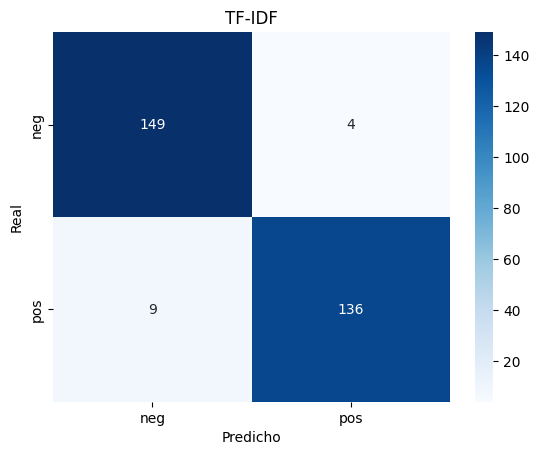

=== TF-IDF + POS/NER ===
              precision    recall  f1-score   support

           0     0.9367    0.9673    0.9518       153
           1     0.9643    0.9310    0.9474       145

    accuracy                         0.9497       298
   macro avg     0.9505    0.9492    0.9496       298
weighted avg     0.9501    0.9497    0.9496       298



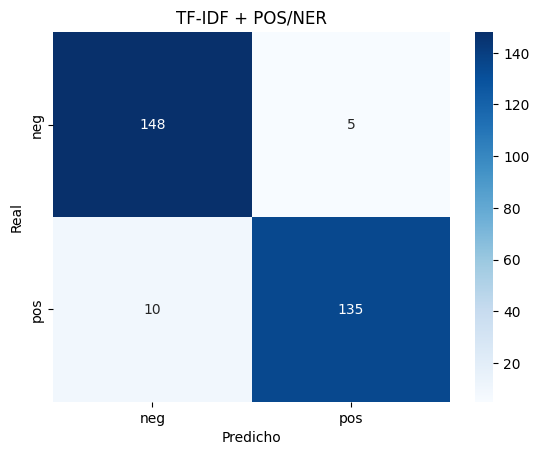

=== POS n-grams ===
              precision    recall  f1-score   support

           0     0.9091    0.9150    0.9121       153
           1     0.9097    0.9034    0.9066       145

    accuracy                         0.9094       298
   macro avg     0.9094    0.9092    0.9093       298
weighted avg     0.9094    0.9094    0.9094       298



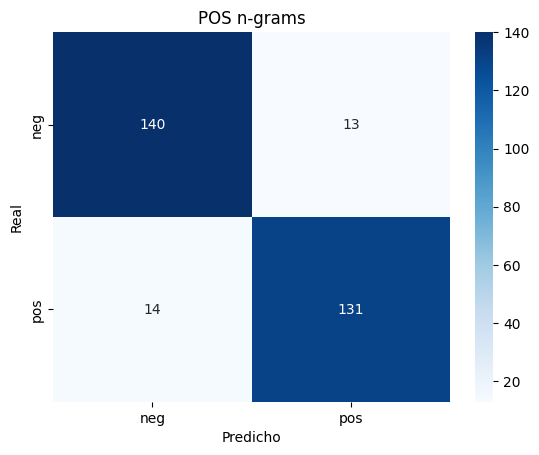

=== NER-enhanced n-grams ===
              precision    recall  f1-score   support

           0     0.9490    0.9739    0.9613       153
           1     0.9716    0.9448    0.9580       145

    accuracy                         0.9597       298
   macro avg     0.9603    0.9593    0.9597       298
weighted avg     0.9600    0.9597    0.9597       298



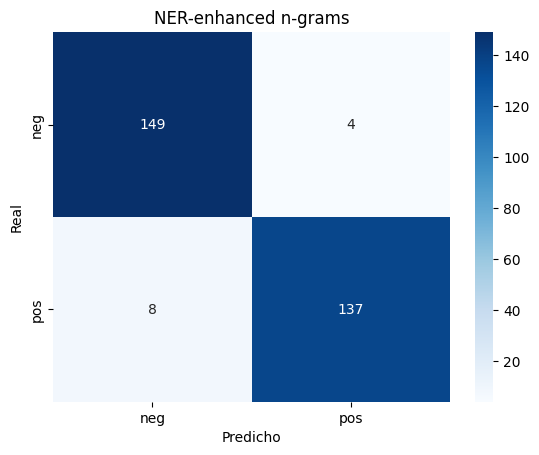

=== Hybrid ===
              precision    recall  f1-score   support

           0     0.9484    0.9608    0.9545       153
           1     0.9580    0.9448    0.9514       145

    accuracy                         0.9530       298
   macro avg     0.9532    0.9528    0.9530       298
weighted avg     0.9531    0.9530    0.9530       298



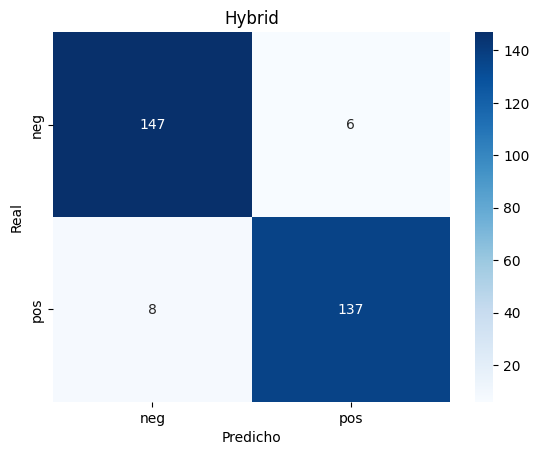

In [ ]:
# Matriz de confusión y reportes
def plot_confusion(y_true, y_pred, labels=['neg','pos'], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicho"); plt.ylabel("Real"); plt.title(title); plt.show()

models = {
    "TF-IDF": clf.predict(X_test_tfidf),
    "TF-IDF + POS/NER": clf_posner.predict(hstack([X_test_tfidf, csr_matrix(Xpos_test), csr_matrix(Xner_test)])),
    "POS n-grams": clf_posng.predict(pos_ngram_vect.transform(test_df['clean_text'].apply(pos_sequence))),
    "NER-enhanced n-grams": clf_nerrep.predict(tfidf_ner.transform(test_df['clean_text'].apply(replace_ents))),
    "Hybrid": clf_hybrid.predict(X_test_hybrid)
}

for name, preds in models.items():
    print(f"=== {name} ===")
    print(classification_report(y_test, preds, digits=4))
    plot_confusion(y_test, preds, title=name)

### <font color= #d4b1e6> **Análisis de resultados** </font>

| Modelo | Exactitud ($\text{Accuracy}$) | F1-Score Macro Promedio | Falsos Positivos ($\text{FP}$) | Falsos Negativos ($\text{FN}$) |
| :--- | :--- | :--- | :--- | :--- |
| **TF-IDF (Baseline)** | $\text{0.9564}$ | $\text{0.9563}$ | $\text{4}$ | $\text{9}$ |
| **TF-IDF + POS/NER** | $\text{0.9497}$ | $\text{0.9496}$ | $\text{5}$ | $\text{10}$ |
| **POS n-grams** | $\text{0.9094}$ | $\text{0.9093}$ | $\text{13}$ | $\text{14}$ |
| **NER-enhanced n-grams** | $\mathbf{0.9597}$ | $\mathbf{0.9597}$ | $\mathbf{4}$ | $\mathbf{8}$ |
| **Hybrid (BERT + POS/NER)** | $\text{0.9530}$ | $\text{0.9530}$ | $\text{6}$ | $\mathbf{8}$ |

---

### Resumen 

El análisis comparativo, basado en las métricas de clasificación y las matrices de confusión, se enfoca en el rendimiento de los modelos en la tarea de Análisis de Sentimiento entre las marcas Nike y Adidas.

* **Líder en Rendimiento:** El modelo **NER-enhanced n-grams** alcanzó la **mayor exactitud ($\mathbf{0.9597}$) y F1-score ($\mathbf{0.9597}$)**. Este enfoque mejoró el *baseline* al generalizar los patrones de sentimiento, cometiendo el menor número de Falsos Negativos ($\mathbf{8}$) junto con el modelo Híbrido.
* **Modelo de Referencia (Baseline):** El modelo simple de **TF-IDF** tuvo un rendimiento muy cercano al mejor, con una exactitud de $\text{0.9564}$, demostrando ser un punto de partida robusto.
* **Impacto de Características Adicionales:**
    * La adición de conteos **POS/NER** a TF-IDF (**TF-IDF + POS/NER**) causó una ligera caída en la exactitud ($\text{0.9497}$), lo que sugiere que las características de conteo no añadieron valor suficiente.
    * El modelo **POS n-grams** (basado solo en secuencias gramaticales) tuvo el rendimiento más bajo ($\text{0.9094}$), lo cual indica que la información léxica (el significado de las palabras) es indispensable para la clasificación en este contexto.
* **Modelo Híbrido:** La combinación de *embeddings* de BERT con conteos POS/NER fue buena ($\text{0.9530}$), pero no logró superar a los mejores métodos de ingeniería de características, indicando que el modelo BERT por sí solo ya tiene un alto poder predictivo que no fue incrementado significativamente por las características clásicas añadidas.

### <font color= #d4b1e6> **Ejemplos mal clasificados** </font>

In [ ]:
# Ejemplos
for name, preds in models.items():
    print(f"=== Mal clasificados {name} ===")
    mis_idx = np.where(y_test != preds)[0][:10]
    for idx in mis_idx:
        print("Index:", idx, "True:", y_test[idx], "Pred:", preds[idx])
        print(test_df['clean_text'].iloc[idx])
        print("---")

=== Mal clasificados TF-IDF ===
Index: 7 True: 1 Pred: 0
should i upgrade about nike's react? , specialoffer curious about your experience too.
---
Index: 25 True: 0 Pred: 1
anyone have tips about nike's flyknit? sale, lifestyle let me know what you think!
---
Index: 61 True: 0 Pred: 1
any advice about adidas's ultraboost? travel, premium, trending would love to get your feedback!
---
Index: 80 True: 1 Pred: 0
what's your opinion about adidas's yeezy? quality, health let me know what you think!
---
Index: 92 True: 1 Pred: 0
any advice about nike's zoom pegasus? deal, newrelease, reviews let me know what you think!
---
Index: 100 True: 0 Pred: 1
what's your opinion about adidas's superstar? sale, affordable really interested in hearing your thoughts!
---
Index: 103 True: 0 Pred: 1
how do i fix about nike's epic react? trendalert, beauty, eco would love to get your feedback!
---
Index: 109 True: 1 Pred: 0
anyone have tips about nike's react? health, promo, tech curious about your experie

Se realiza la evaluación y visualización donde primero muestran las métricas de rendimiento, se dibuja la matriz de confusión para cada modelos, compara el desempeño de todas las variantes e imprime ejemplos mal clasificados.

Los modelos predijeron incorrectamente estos ejemplos debido a su dificultad para interpretar el contexto implícito y manejar el lenguaje de opinión en redes sociales. Los Falsos Negativos ocurren porque los modelos, especialmente los basados en TF-IDF, sobreponderan la neutralidad de las preguntas como: "should i upgrade?", "any advice?", "what's your opinion?", e ignoran el sentimiento positivo notorio en los hashtags o en la intención de la consulta. Por otro lado, los Falsos Positivos se deben a que los modelos dan demasiado peso a los términos positivos como "sale," "affordable" o "trending", y fallan en reconocer el sentimiento negativo explícito en el texto: "disappointing," "subpar," "underwhelming," o frases que implican un problema como "how do i fix".

### <font color= #d4b1e6> **Conclusiones** </font>

Este proyecto nos permitió explorar cómo las técnicas de análisis de sentimiento pueden ayudar a entender lo que la gente opina sobre marcas como Nike y Adidas.
Al comparar métodos tradicionales, como TF-IDF con regresión logística, con modelos más recientes como BERT, pudimos notar que los enfoques modernos logran captar mejor el contexto y las emociones en los textos.

Además, al incluir POS y NER, el análisis fue más completo, ya que pudimos identificar entidades y estructuras dentro de las oraciones, no solo el tono general del mensaje.
En general, combinar diferentes técnicas nos ayudó a obtener resultados más claros y confiables, mostrando cómo el NLP puede ser una herramienta muy útil para entender la percepción de los usuarios en redes sociales.